In [ ]:
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 108.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does n

In [ ]:
!pip install rouge

Explanation of the installed dependencies:

* bitsandbytes — Lightweight CUDA library for 8-bit optimizers and quantization (speeds up model training/inference).

* accelerate — Simplifies running models on different hardware (CPU, GPU, multi-GPU) without manual device management.

* xformers==0.0.29.post3 — Meta’s library for efficient transformer blocks (e.g., memory-efficient attention).

* peft — Library for Parameter-Efficient Fine-Tuning (like LoRA, adapters) of large models.

* trl — Library for Training language models with Reinforcement Learning (e.g., PPO, DPO training).

* triton — High-performance GPU programming language used to speed up deep learning operations.

* cut_cross_entropy — Provides a faster, memory-efficient implementation of cross-entropy loss for large models.

* unsloth_zoo — Collection of lightweight, optimized pre-trained models from the Unsloth project.

* sentencepiece — Tokenizer for subword-based models like T5, BERT, LLaMA (especially for multilingual tasks).

* protobuf — Google's serialization framework; essential for model saving/loading and communication in ML pipelines.

* datasets — Hugging Face library to easily load, preprocess, and share datasets for ML training and evaluation.

* huggingface_hub — Client to download/upload models, datasets, and spaces from/to Hugging Face Hub.

* hf_transfer — Accelerates file transfers to/from Hugging Face Hub (especially large models or datasets).

* unsloth — Core library enabling extremely memory-efficient fine-tuning of large language models (LoRA + speed optimizations).



# Install and Import Necessary Libraries

In [ ]:
from unsloth import FastVisionModel, is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from datasets import load_dataset
from transformers import TextStreamer
from trl import SFTTrainer, SFTConfig
import torch
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


Explanation of the Imported Libraries:

* unsloth.FastVisionModel: Loads and fine-tunes vision-language models efficiently (optimized for low memory use).

* unsloth.is_bf16_supported: Checks if your hardware supports bf16 (bfloat16) for faster, lower-precision training.

* unsloth.trainer.UnslothVisionDataCollator: Prepares batches (text + images) correctly for training vision-language models.

* datasets.load_dataset: Loads datasets easily from Hugging Face’s hub or local files.

* transformers.TextStreamer: Streams generated text token-by-token while the model is decoding (helps monitor outputs live).

* trl.SFTTrainer: Fine-tunes models on supervised data (SFT = Supervised Fine-Tuning).

* trl.SFTConfig: Configuration object that holds all fine-tuning settings for SFTTrainer.

* torch: Core PyTorch library for building and training neural networks.

* matplotlib.pyplot: For plotting graphs (like loss, accuracy over epochs).

* nltk.translate.bleu_score: Calculates BLEU score (metric to compare generated text against the reference).

# Load and Preprocess the Dataset

In [ ]:
dataset = load_dataset("unsloth/Latex_OCR", split="train")

README.md:   0%|          | 0.00/519 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/344M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/38.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/68686 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7632 [00:00<?, ? examples/s]

# Visualize some examples from Dataset

In [ ]:
def visualize_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(num_samples, 1, figsize=(5, num_samples * 2))

    if num_samples == 1:
        axes = [axes]

    for idx, ax in enumerate(axes):
        sample = dataset[idx]
        image = sample["image"]
        text = sample["text"]

        ax.imshow(image)
        ax.axis("off")
        ax.set_title(f"LaTeX: {text}", fontsize=10, pad=10)

    plt.tight_layout()
    plt.show()

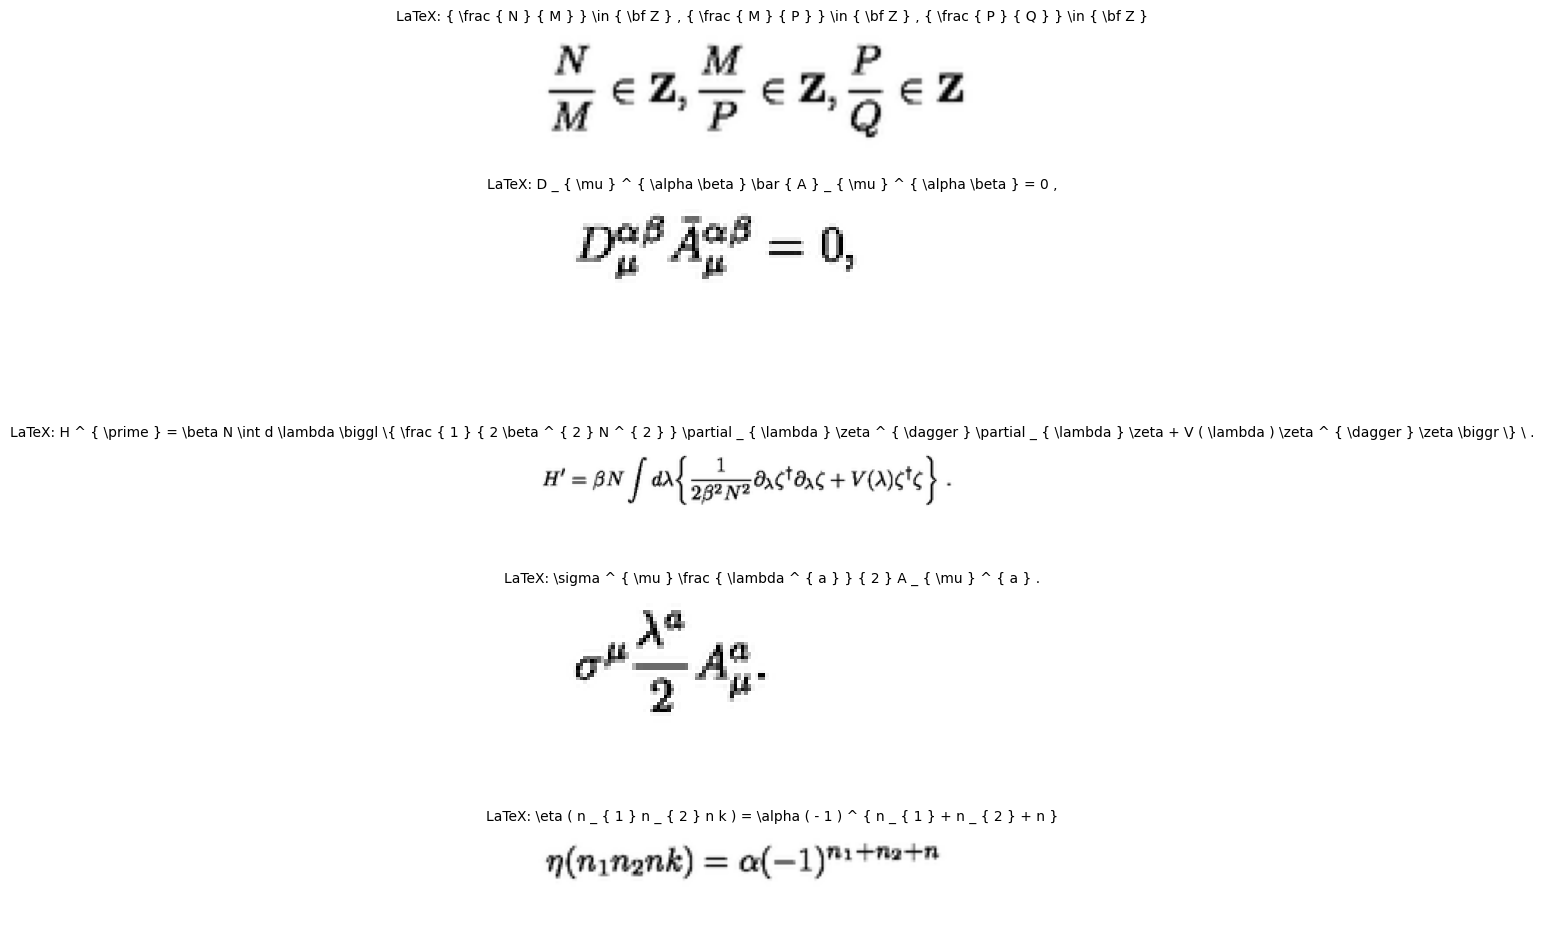

In [ ]:
# Visualize 5 samples
visualize_samples(dataset)

# **Llava**

# Load the Pretrained 4-bit LLaVA Model



In [ ]:
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/LLaVA-1.5-7B-hf",
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth"
)

==((====))==  Unsloth 2025.4.7: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.04G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

# Apply LoRA

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers=True, # Enable fine-tuning for the vision encoder layers
    finetune_language_layers=True, # Enable fine-tuning for the language model layers
    finetune_attention_modules=True, # Fine-tune the attention heads/modules inside the transformer layers.
    finetune_mlp_modules=True, # Fine-tune the MLP (feed-forward) layers inside the model
    r=16, # Rank (r) for LoRA; smaller values mean lighter, faster adaptation (low-rank matrices of size 16).
    lora_alpha=16, # Scaling factor for LoRA updates to control learning strength.
    lora_dropout=0, # No dropout applied during LoRA fine-tuning (stable updates).
    bias="none", # o not fine-tune biases (only focus on LoRA weights).
    random_state=3407, # Fix random seed for reproducibility
    use_rslora=False, #Do not use RS-LoRA (a variant that can save more memory, not used here).
    loftq_config=None # No special LoFTQ (quantization) configuration is applied; pure LoRA.
)

Unsloth: Making `base_model.model.vision_tower.vision_model` require gradients


# Prepare Data Using Text + Image format

In [ ]:
instruction = "Write the LaTex representation for this image."

In [ ]:
def convert_to_llava_prompt(sample):
    return {
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": instruction},
                    {"type": "image", "image": sample["image"]}
                ]
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": sample["text"]}
                ]
            }
        ],
    }

In [ ]:
converted_dataset = [convert_to_llava_prompt(sample) for sample in dataset]

# Prepare for Training

In [ ]:
FastVisionModel.for_inference(model)  # Set model to inference mode

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlavaForConditionalGeneration(
      (vision_tower): CLIPVisionModel(
        (vision_model): CLIPVisionTransformer(
          (embeddings): CLIPVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
            (position_embedding): Embedding(577, 1024)
          )
          (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (encoder): CLIPEncoder(
            (layers): ModuleList(
              (0-23): 24 x CLIPEncoderLayer(
                (self_attn): CLIPSdpaAttention(
                  (k_proj): lora.Linear4bit(
                    (base_layer): Linear4bit(in_features=1024, out_features=1024, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Identity()
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=1024, out_features=16,

In [ ]:
# Setup trainer
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=UnslothVisionDataCollator(model, tokenizer),
    train_dataset=converted_dataset,
    args=SFTConfig(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=10,
        max_steps=1000,
        gradient_checkpointing=True,
        learning_rate=3e-5,
        fp16=not is_bf16_supported(),
        bf16=is_bf16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        report_to="none",
        remove_unused_columns=False,
        dataset_text_field="",
        dataset_kwargs={"skip_prepare_dataset": True},
        dataset_num_proc=4,
        max_seq_length=2048,
    ),
)

# Train the Model

In [ ]:
train_output = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 68,686 | Num Epochs = 1 | Total steps = 300
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 47,054,848/7,000,000,000 (0.67% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,11.568400
2,12.638700
3,13.841800
4,11.739300
5,12.673800
6,14.863300
7,13.544900
8,11.566400
9,10.826200
10,12.384800


# Visualize Training Loss

In [ ]:
def plot_loss(trainer_log_history):
    losses = [log["loss"] for log in trainer_log_history if "loss" in log]
    steps = range(len(losses))
    plt.plot(steps, losses, marker="o")
    plt.title("Training Loss over Steps")
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

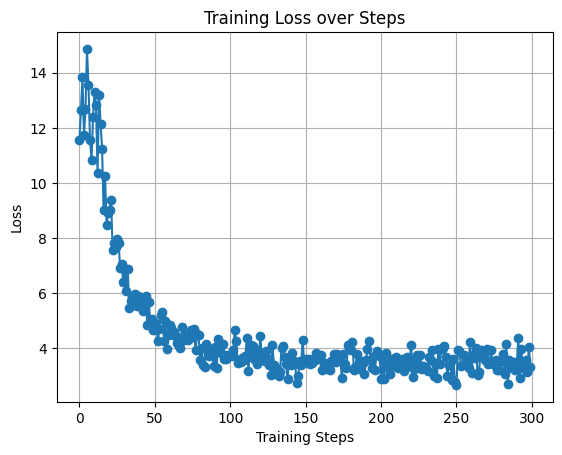

In [ ]:
plot_loss(trainer.state.log_history)

# Inference After Training

In [ ]:
FastVisionModel.for_inference(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlavaForConditionalGeneration(
      (vision_tower): CLIPVisionModel(
        (vision_model): CLIPVisionTransformer(
          (embeddings): CLIPVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
            (position_embedding): Embedding(577, 1024)
          )
          (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (encoder): CLIPEncoder(
            (layers): ModuleList(
              (0-23): 24 x CLIPEncoderLayer(
                (self_attn): CLIPSdpaAttention(
                  (k_proj): lora.Linear4bit(
                    (base_layer): Linear4bit(in_features=1024, out_features=1024, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Identity()
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=1024, out_features=16,

In [ ]:
# Pick a sample image for testing
sample = dataset[1]
image = sample["image"]
instruction = "Write the LaTeX representation for this image."

# Format as LLaVA-style input
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": instruction},
            {"type": "image", "image": sample["image"]}
        ]
    }
]

input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
inputs = tokenizer(image, input_text, add_special_tokens=False, return_tensors="pt").to("cuda")

# Generate prediction
text_streamer = TextStreamer(tokenizer, skip_prompt=True)
generated_outputs = model.generate(**inputs, streamer=text_streamer, max_new_tokens=128, use_cache=True, temperature=0.7, min_p=0.1)

\alpha f \ f \ as 2-f the Euler's 1-leave-o-4 to the -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -pi -


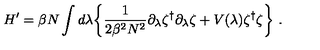

In [ ]:
image

# Evaluate using BLEU Score

In [ ]:
# Ground Truth
reference_text = dataset[2]["text"]

In [ ]:
outputs = model.generate(**inputs, max_new_tokens=128)
generated_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

In [ ]:
# Compute BLEU
smooth = SmoothingFunction().method1
bleu_score = sentence_bleu(
    [reference_text.split()],
    generated_text.split(),
    smoothing_function=smooth
)

In [ ]:
print(f"\nReference Text: {reference_text}")
print(f"Generated Text: {generated_text}")
print(f"BLEU Score: {bleu_score:.4f}")


Reference Text: H ^ { \prime } = \beta N \int d \lambda \biggl \{ \frac { 1 } { 2 \beta ^ { 2 } N ^ { 2 } } \partial _ { \lambda } \zeta ^ { \dagger } \partial _ { \lambda } \zeta + V ( \lambda ) \zeta ^ { \dagger } \zeta \biggr \} \ .
Generated Text: USER:  
Write the LaTeX representation for this image. ASSISTANT: \alpha f _ 1 \ f ( x = 0 ( 1 used to denote the 4 - 0 - 0 (3 to 1 ) d d d d d d d d d d d d d d ( t o d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d
BLEU Score: 0.0023


# Evaluate using ROUGE

In [ ]:
from rouge import Rouge

rouge = Rouge()
scores = rouge.get_scores(generated_text, reference_text)[0]
print(f"ROUGE-L: {scores['rouge-l']}")

ROUGE-L: {'r': 0.1111111111111111, 'p': 0.10714285714285714, 'f': 0.10909090409256221}


In [ ]:
# Evaluate on 10% validation split — LLaVA (BLEU, ROUGE-L, Exact-Match, SER, Levenshtein)
import math
import torch
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge

# Safe import for Levenshtein with fallback install
try:
    from Levenshtein import distance as levenshtein_distance
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "python-Levenshtein", "-q"])  # noqa: S603
    from Levenshtein import distance as levenshtein_distance

# Build a simple 10% validation slice without shuffling (deterministic)
val_size = max(1, int(0.10 * len(dataset)))
val_indices = list(range(val_size))
val_images = [dataset[i]["image"] for i in val_indices]
val_refs = [dataset[i]["text"] for i in val_indices]

# Ensure inference mode
FastVisionModel.for_inference(model)
model.eval()

instruction_eval = "Write the LaTeX representation for this image."

def generate_prediction_llava(sample_image):
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction_eval},
                {"type": "image", "image": sample_image},
            ],
        }
    ]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
    inputs = tokenizer(sample_image, input_text, add_special_tokens=False, return_tensors="pt").to("cuda")
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=128,
            use_cache=True,
            temperature=0.7,
            min_p=0.1,
        )
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

preds = []
for img in val_images:
    preds.append(generate_prediction_llava(img))

# Compute metrics
smooth = SmoothingFunction().method1
rouge = Rouge()
bleu_scores = []
rouge_l_f = []
exact_matches = []
lev_dists = []
sers = []  # String Error Rate (normalized Levenshtein)

for pred, ref in zip(preds, val_refs):
    bleu_scores.append(sentence_bleu([ref.split()], pred.split(), smoothing_function=smooth))
    r = rouge.get_scores(pred, ref)[0]["rouge-l"]["f"]
    rouge_l_f.append(r)
    exact_matches.append(1.0 if pred.strip() == ref.strip() else 0.0)
    dist = levenshtein_distance(pred, ref)
    lev_dists.append(dist)
    sers.append(dist / max(1, len(ref)))

def _mean(values):
    return float(sum(values) / max(1, len(values)))

print(f"Validation size: {val_size}")
print(f"BLEU: {_mean(bleu_scores):.4f}")
print(f"ROUGE-L(F1): {_mean(rouge_l_f):.4f}")
print(f"Exact-Match: {_mean(exact_matches):.4f}")
print(f"Levenshtein: {_mean(lev_dists):.2f}")
print(f"SER: {_mean(sers):.4f}")


# **Qwen VL**

# Load the Pretrained 4-bit Model

In [ ]:
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2-VL-7B-Instruct",
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth"
)

==((====))==  Unsloth 2025.4.7: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/6.85G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/4.33k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

# Apply LoRA

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers=True, # Enable fine-tuning for the vision encoder layers
    finetune_language_layers=True, # Enable fine-tuning for the language model layers
    finetune_attention_modules=True, # Fine-tune the attention heads/modules inside the transformer layers.
    finetune_mlp_modules=True, # Fine-tune the MLP (feed-forward) layers inside the model
    r=16, # Rank (r) for LoRA; smaller values mean lighter, faster adaptation (low-rank matrices of size 16).
    lora_alpha=16, # Scaling factor for LoRA updates to control learning strength.
    lora_dropout=0, # No dropout applied during LoRA fine-tuning (stable updates).
    bias="none", # o not fine-tune biases (only focus on LoRA weights).
    random_state=3407, # Fix random seed for reproducibility
    use_rslora=False, #Do not use RS-LoRA (a variant that can save more memory, not used here).
    loftq_config=None # No special LoFTQ (quantization) configuration is applied; pure LoRA.
)

Unsloth: Making `model.base_model.model.visual` require gradients


# Prepare the Dataset in Conversation Format

In [ ]:
instruction = "Write the LaTex representation for this image."

In [ ]:
# Define a function to convert samples into conversation format
def convert_to_conversation(sample):
    conversation = [
        {"role": "user",
         "content": [
             {"type": "text", "text": instruction},
             {"type": "image", "image": sample["image"]}
         ]},
        {"role": "assistant",
         "content": [
             {"type": "text", "text": sample["text"]}
         ]}
    ]
    return {"messages": conversation}

In [ ]:
# Apply conversion to all samples
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

# Prepare for Training

In [ ]:
FastVisionModel.for_inference(model)  # Set model to inference mode

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2VLForConditionalGeneration(
      (visual): Qwen2VisionTransformerPretrainedModel(
        (patch_embed): PatchEmbed(
          (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
        (rotary_pos_emb): VisionRotaryEmbedding()
        (blocks): ModuleList(
          (0-18): 19 x Qwen2VLVisionBlock(
            (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
            (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
            (attn): VisionSdpaAttention(
              (qkv): lora.Linear(
                (base_layer): Linear(in_features=1280, out_features=3840, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1280, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(


In [ ]:
trainer = SFTTrainer(
    model=model,  # The model to be fine-tuned
    tokenizer=tokenizer,  # Tokenizer used for preprocessing
    data_collator=UnslothVisionDataCollator(model, tokenizer),  # Collates data into batch format
    train_dataset=converted_dataset,  # Dataset used for training
    args=SFTConfig(
        per_device_train_batch_size=2,  # Batch size per GPU
        gradient_accumulation_steps=4,  # Accumulate gradients over 4 steps to simulate larger batch size
        warmup_steps=30,  # Gradual learning rate warmup steps at the start of training
        max_steps=1000,  # Total number of training steps
        gradient_checkpointing=True,  # Save memory by checkpointing gradients
        learning_rate=3e-5,  # Initial learning rate
        fp16=not is_bf16_supported(),  # Use FP16 if BF16 not supported (saves memory)
        bf16=is_bf16_supported(),  # Use BF16 if supported (better numerical stability)
        logging_steps=1,  # Log metrics every step
        optim="adamw_8bit",  # Use 8-bit AdamW optimizer to save memory
        weight_decay=0.01,  # Regularization to avoid overfitting
        lr_scheduler_type="linear",  # Linear decay of learning rate
        seed=3407,  # Seed for reproducibility
        output_dir="outputs",  # Directory to save model outputs
        report_to="none",  # Disable reporting to tools like WandB
        remove_unused_columns=False,  # Keep all dataset columns
        dataset_text_field="",  # Text field name in dataset (left empty here)
        dataset_kwargs={"skip_prepare_dataset": True},  # Skip preprocessing again
        dataset_num_proc=4,  # Use 4 processes for data loading
        max_seq_length=2048,  # Max token length for input sequences
    ),
)


Unsloth: Model does not have a default image size - using 512


# Train the Model

In [ ]:
train_output = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 68,686 | Num Epochs = 1 | Total steps = 1,000
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 50,855,936/7,000,000,000 (0.73% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.184900
2,1.332900
3,1.465900
4,1.118200
5,1.204800
6,1.448500
7,1.444200
8,1.195500
9,1.041300
10,1.328900


# Visualize Training Loss

In [ ]:
def plot_loss(trainer_log_history):
    losses = [log["loss"] for log in trainer_log_history if "loss" in log]
    steps = range(len(losses))
    plt.plot(steps, losses, marker="o")
    plt.title("Training Loss over Steps")
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

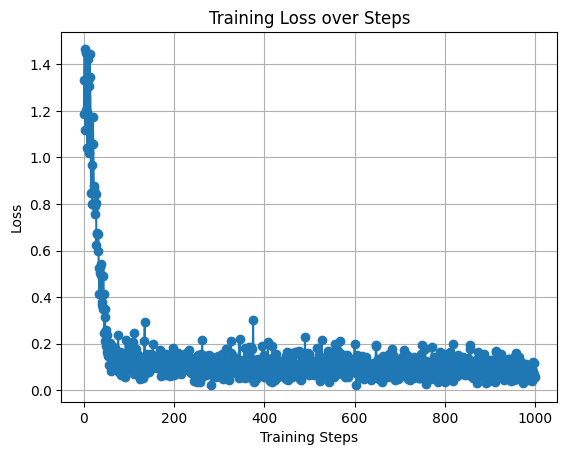

In [ ]:
plot_loss(trainer.state.log_history)

# Inference After Training

In [ ]:
FastVisionModel.for_inference(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2VLForConditionalGeneration(
      (visual): Qwen2VisionTransformerPretrainedModel(
        (patch_embed): PatchEmbed(
          (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
        (rotary_pos_emb): VisionRotaryEmbedding()
        (blocks): ModuleList(
          (0-18): 19 x Qwen2VLVisionBlock(
            (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
            (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
            (attn): VisionSdpaAttention(
              (qkv): lora.Linear(
                (base_layer): Linear(in_features=1280, out_features=3840, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1280, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(


In [ ]:
# Pick a sample image for testing
image = dataset[2]["image"]
instruction = "Write the LaTeX representation for this image."
messages = [
    {"role": "user", "content": [
        {"type": "text", "text": instruction},
        {"type": "image", "image": image}
    ]}
]

input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
inputs = tokenizer(image, input_text, add_special_tokens=False, return_tensors="pt").to("cuda")

# Generate prediction
text_streamer = TextStreamer(tokenizer, skip_prompt=True)
generated_outputs = model.generate(**inputs, streamer=text_streamer, max_new_tokens=128, use_cache=True, temperature=1.5, min_p=0.1)

H ^ { \prime } = \beta N \int d \lambda \left\{ \frac { 1 } { 2 \beta ^ { 2 } N ^ { 2 } } \partial _ { \lambda } \zeta ^ { \dagger } \partial _ { \lambda } \zeta + V ( \lambda ) \zeta ^ { \dagger } \zeta \right\} \ .<|im_end|>


# Evaluate using BLEU Score

In [ ]:
# Ground Truth
reference_text = dataset[2]["text"]

In [ ]:
outputs = model.generate(**inputs, max_new_tokens=128)
generated_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

In [ ]:
# Compute BLEU
smooth = SmoothingFunction().method1
bleu_score = sentence_bleu(
    [reference_text.split()],
    generated_text.split(),
    smoothing_function=smooth
)

In [ ]:
print(f"\nReference Text: {reference_text}")
print(f"Generated Text: {generated_text}")
print(f"BLEU Score: {bleu_score:.4f}")


Reference Text: H ^ { \prime } = \beta N \int d \lambda \biggl \{ \frac { 1 } { 2 \beta ^ { 2 } N ^ { 2 } } \partial _ { \lambda } \zeta ^ { \dagger } \partial _ { \lambda } \zeta + V ( \lambda ) \zeta ^ { \dagger } \zeta \biggr \} \ .
Generated Text: system
You are a helpful assistant.
user
Write the LaTeX representation for this image.
assistant
H ^ { \prime } = \beta N \int d \lambda \left\{ \frac { 1 } { 2 \beta ^ { 2 } N ^ { 2 } } \partial _ { \lambda } \zeta ^ { \dagger } \partial _ { \lambda } \zeta + V ( \lambda ) \zeta ^ { \dagger } \zeta \right\} \ .
BLEU Score: 0.7265


# Evaluate Using ROUGE

In [ ]:
from rouge import Rouge

rouge = Rouge()
scores = rouge.get_scores(generated_text, reference_text)[0]
print(f"ROUGE-L: {scores['rouge-l']}")

ROUGE-L: {'r': 0.8518518518518519, 'p': 0.5897435897435898, 'f': 0.6969696921349864}


In [ ]:
# Evaluate on 10% validation split — Qwen (BLEU, ROUGE-L, Exact-Match, SER, Levenshtein)
import math
import torch
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge

try:
    from Levenshtein import distance as levenshtein_distance
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "python-Levenshtein", "-q"])  # noqa: S603
    from Levenshtein import distance as levenshtein_distance

val_size = max(1, int(0.10 * len(dataset)))
val_indices = list(range(val_size))
val_images = [dataset[i]["image"] for i in val_indices]
val_refs = [dataset[i]["text"] for i in val_indices]

FastVisionModel.for_inference(model)
model.eval()

instruction_eval = "Write the LaTeX representation for this image."

def generate_prediction_qwen(sample_image):
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction_eval},
                {"type": "image", "image": sample_image},
            ],
        }
    ]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
    inputs = tokenizer(sample_image, input_text, add_special_tokens=False, return_tensors="pt").to("cuda")
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=128,
            use_cache=True,
            temperature=1.0,
            min_p=0.1,
        )
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

preds = [generate_prediction_qwen(img) for img in val_images]

smooth = SmoothingFunction().method1
rouge = Rouge()
bleu_scores = []
rouge_l_f = []
exact_matches = []
lev_dists = []
sers = []

for pred, ref in zip(preds, val_refs):
    bleu_scores.append(sentence_bleu([ref.split()], pred.split(), smoothing_function=smooth))
    r = rouge.get_scores(pred, ref)[0]["rouge-l"]["f"]
    rouge_l_f.append(r)
    exact_matches.append(1.0 if pred.strip() == ref.strip() else 0.0)
    dist = levenshtein_distance(pred, ref)
    lev_dists.append(dist)
    sers.append(dist / max(1, len(ref)))

print(f"Validation size: {val_size}")
print(f"BLEU: {sum(bleu_scores)/max(1,len(bleu_scores)):.4f}")
print(f"ROUGE-L(F1): {sum(rouge_l_f)/max(1,len(rouge_l_f)):.4f}")
print(f"Exact-Match: {sum(exact_matches)/max(1,len(exact_matches)):.4f}")
print(f"Levenshtein: {sum(lev_dists)/max(1,len(lev_dists)):.2f}")
print(f"SER: {sum(sers)/max(1,len(sers)):.4f}")
